In [3]:
!which python

/home/paperspace/anaconda3/envs/fastai/bin/python


In [4]:
import sys
sys.path.append('..')

In [11]:
import enum
import math
import pdb
import platform
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook
from albumentations import Compose, HorizontalFlip

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TransformsTrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel
from ssdmultibox import utils
from ssdmultibox.plotting import *

import matplotlib.pyplot as plt
plt.ion()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
device

device(type='cuda', index=0)

In [7]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [8]:
model = SSDModel().to(device)

In [15]:
LR = 1e-3
SSD_LOSS_ALPHA = 100

criterion = SSDLoss(alpha=SSD_LOSS_ALPHA)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
current_time = time.time()

In [16]:
train_dataset = TransformsTrainPascalFlatDataset(
    transform=Compose([HorizontalFlip(p=0.5)],
                       bbox_params={'format': 'coco', 'label_fields': ['category_id']}))

len(train_dataset)

2501

In [17]:
NUM_WORKERS = utils.get_cpu_count()
BATCH = 16
SHUFFLE = True
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

vars(dataloader)

{'dataset': <ssdmultibox.datasets.TransformsTrainPascalFlatDataset at 0x7f7ce8018240>,
 'batch_size': 16,
 'num_workers': 8,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f7ce8018b00>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f7ce8018940>,
 '_DataLoader__initialized': True}

In [18]:
EPOCHS = 3

for epoch in range(EPOCHS):
    scheduler.step()
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if step % 5 == 0:
            print('epoch: {} step: {} loss: {:.4f} time: {:.4f}'.format(
                epoch, step, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())

pos_loss: 1731.3376 neg_hard_mining_loss: 5175.7690
n: 125.0 bbs_loss: 250.8713 cats_loss: 6907.1064
epoch: 0 step: 0 loss: 57.2638 time: 2.8103
pos_loss: 1690.1830 neg_hard_mining_loss: 5053.1890
n: 122.0 bbs_loss: 233.0615 cats_loss: 6743.3716
pos_loss: 1136.2605 neg_hard_mining_loss: 3397.2795
n: 82.0 bbs_loss: 147.3166 cats_loss: 4533.5396
pos_loss: 1537.6335 neg_hard_mining_loss: 4574.2451
n: 111.0 bbs_loss: 207.7637 cats_loss: 6111.8789
pos_loss: 1606.2622 neg_hard_mining_loss: 4773.3081
n: 116.0 bbs_loss: 134.7730 cats_loss: 6379.5703
pos_loss: 2216.3303 neg_hard_mining_loss: 6549.6245
n: 160.0 bbs_loss: 262.7596 cats_loss: 8765.9551
epoch: 0 step: 5 loss: 56.4295 time: 6.9313
pos_loss: 1369.5582 neg_hard_mining_loss: 4055.0312
n: 99.0 bbs_loss: 133.5520 cats_loss: 5424.5898
pos_loss: 2129.5549 neg_hard_mining_loss: 6227.6167
n: 154.0 bbs_loss: 195.3618 cats_loss: 8357.1709
pos_loss: 1966.2026 neg_hard_mining_loss: 5756.7061
n: 142.0 bbs_loss: 238.0889 cats_loss: 7722.9092
pos_l

pos_loss: 1404.2832 neg_hard_mining_loss: 2828.9465
n: 103.0 bbs_loss: 189.3391 cats_loss: 4233.2300
epoch: 0 step: 75 loss: 42.9376 time: 6.8456
pos_loss: 1703.7482 neg_hard_mining_loss: 3086.1094
n: 126.0 bbs_loss: 132.9927 cats_loss: 4789.8579
pos_loss: 2298.0383 neg_hard_mining_loss: 4465.2197
n: 169.0 bbs_loss: 298.9935 cats_loss: 6763.2593
pos_loss: 1260.3719 neg_hard_mining_loss: 2526.3777
n: 94.0 bbs_loss: 95.6217 cats_loss: 3786.7498
pos_loss: 1484.4110 neg_hard_mining_loss: 2838.5596
n: 109.0 bbs_loss: 172.6226 cats_loss: 4322.9707
pos_loss: 1722.6343 neg_hard_mining_loss: 3223.0017
n: 127.0 bbs_loss: 134.1055 cats_loss: 4945.6357
epoch: 0 step: 80 loss: 39.9980 time: 6.8193
pos_loss: 1294.2542 neg_hard_mining_loss: 2188.0146
n: 95.0 bbs_loss: 129.8928 cats_loss: 3482.2690
pos_loss: 1564.5881 neg_hard_mining_loss: 2912.4729
n: 117.0 bbs_loss: 147.2333 cats_loss: 4477.0615
pos_loss: 1759.0430 neg_hard_mining_loss: 2946.5439
n: 131.0 bbs_loss: 259.1516 cats_loss: 4705.5874
pos_

pos_loss: 1410.4463 neg_hard_mining_loss: 1935.8802
n: 106.0 bbs_loss: 145.5544 cats_loss: 3346.3264
epoch: 0 step: 150 loss: 32.9423 time: 6.3249
pos_loss: 2554.4746 neg_hard_mining_loss: 866.6487
n: 192.0 bbs_loss: 156.6811 cats_loss: 3421.1235
pos_loss: 1552.6321 neg_hard_mining_loss: 2026.4724
n: 119.0 bbs_loss: 159.6976 cats_loss: 3579.1040
pos_loss: 2032.3645 neg_hard_mining_loss: 2273.9133
n: 155.0 bbs_loss: 207.3808 cats_loss: 4306.2778
pos_loss: 1853.3995 neg_hard_mining_loss: 2542.6248
n: 140.0 bbs_loss: 209.8134 cats_loss: 4396.0239
pos_loss: 1146.9872 neg_hard_mining_loss: 1310.8419
n: 85.0 bbs_loss: 157.3345 cats_loss: 2457.8293
epoch: 0 step: 155 loss: 30.7666 time: 6.4819
pos_loss: 1930.0950 neg_hard_mining_loss: 2678.7078
n: 144.0 bbs_loss: 343.7520 cats_loss: 4608.8027



pos_loss: 1528.6116 neg_hard_mining_loss: 1985.0421
n: 116.0 bbs_loss: 200.4327 cats_loss: 3513.6536
epoch: 1 step: 0 loss: 32.0180 time: 2.7474
pos_loss: 1557.5632 neg_hard_mining_loss: 1873.9221
n: 116.0 bbs_loss: 220.0527 cats_loss: 3431.4858
pos_loss: 1731.2831 neg_hard_mining_loss: 2258.5706
n: 129.0 bbs_loss: 127.4126 cats_loss: 3989.8535
pos_loss: 1764.6985 neg_hard_mining_loss: 1918.6309
n: 135.0 bbs_loss: 230.6228 cats_loss: 3683.3293
pos_loss: 1972.7098 neg_hard_mining_loss: 1813.0118
n: 148.0 bbs_loss: 185.7533 cats_loss: 3785.7217
pos_loss: 1342.9922 neg_hard_mining_loss: 1201.8761
n: 100.0 bbs_loss: 178.4818 cats_loss: 2544.8682
epoch: 1 step: 5 loss: 27.2335 time: 6.4945
pos_loss: 1913.9352 neg_hard_mining_loss: 2133.5923
n: 145.0 bbs_loss: 114.8095 cats_loss: 4047.5276
pos_loss: 2056.3916 neg_hard_mining_loss: 2265.0596
n: 158.0 bbs_loss: 249.2963 cats_loss: 4321.4512
pos_loss: 1946.8774 neg_hard_mining_loss: 2598.4358
n: 148.0 bbs_loss: 97.3920 cats_loss: 4545.3130
pos_

pos_loss: 1776.6709 neg_hard_mining_loss: 2004.6909
n: 137.0 bbs_loss: 185.4232 cats_loss: 3781.3618
epoch: 1 step: 75 loss: 28.9546 time: 7.0660
pos_loss: 1484.0267 neg_hard_mining_loss: 1436.8104
n: 115.0 bbs_loss: 315.1256 cats_loss: 2920.8374
pos_loss: 1344.8079 neg_hard_mining_loss: 1351.6879
n: 103.0 bbs_loss: 259.8251 cats_loss: 2696.4956
pos_loss: 1367.0112 neg_hard_mining_loss: 1643.3561
n: 109.0 bbs_loss: 147.0495 cats_loss: 3010.3674
pos_loss: 1602.7527 neg_hard_mining_loss: 834.5817
n: 127.0 bbs_loss: 174.7698 cats_loss: 2437.3345
pos_loss: 1586.6426 neg_hard_mining_loss: 1979.3660
n: 124.0 bbs_loss: 160.9129 cats_loss: 3566.0085
epoch: 1 step: 80 loss: 30.0558 time: 6.4257
pos_loss: 1542.6699 neg_hard_mining_loss: 1402.3857
n: 121.0 bbs_loss: 184.3993 cats_loss: 2945.0554
pos_loss: 1594.7958 neg_hard_mining_loss: 1833.8743
n: 126.0 bbs_loss: 210.5083 cats_loss: 3428.6699
pos_loss: 1460.7747 neg_hard_mining_loss: 1130.4943
n: 117.0 bbs_loss: 125.5339 cats_loss: 2591.2693
po

pos_loss: 980.8898 neg_hard_mining_loss: 1241.1082
n: 98.0 bbs_loss: 137.8306 cats_loss: 2221.9980
epoch: 1 step: 150 loss: 24.0799 time: 6.4926
pos_loss: 1022.8868 neg_hard_mining_loss: 814.5596
n: 124.0 bbs_loss: 165.7776 cats_loss: 1837.4464
pos_loss: 1386.3473 neg_hard_mining_loss: 1873.8668
n: 162.0 bbs_loss: 198.9453 cats_loss: 3260.2144
pos_loss: 1422.2958 neg_hard_mining_loss: 1587.5587
n: 169.0 bbs_loss: 263.8448 cats_loss: 3009.8545
pos_loss: 1197.8770 neg_hard_mining_loss: 1422.2556
n: 154.0 bbs_loss: 166.9803 cats_loss: 2620.1326
pos_loss: 701.9769 neg_hard_mining_loss: 783.9338
n: 106.0 bbs_loss: 118.8320 cats_loss: 1485.9106
epoch: 1 step: 155 loss: 15.1391 time: 6.3717
pos_loss: 975.8158 neg_hard_mining_loss: 703.6568
n: 118.0 bbs_loss: 180.9179 cats_loss: 1679.4725



pos_loss: 631.1077 neg_hard_mining_loss: 827.2124
n: 78.0 bbs_loss: 112.8044 cats_loss: 1458.3201
epoch: 2 step: 0 loss: 20.1426 time: 2.5413
pos_loss: 1084.6215 neg_hard_mining_loss: 2014.7603
n: 175.0 bbs_loss: 140.8122 cats_loss: 3099.3818
pos_loss: 490.8519 neg_hard_mining_loss: 771.9100
n: 74.0 bbs_loss: 110.2783 cats_loss: 1262.7620
pos_loss: 807.3893 neg_hard_mining_loss: 970.0772
n: 124.0 bbs_loss: 183.8033 cats_loss: 1777.4666
pos_loss: 936.3738 neg_hard_mining_loss: 1758.4714
n: 172.0 bbs_loss: 275.3170 cats_loss: 2694.8452
pos_loss: 1160.0212 neg_hard_mining_loss: 1894.1565
n: 189.0 bbs_loss: 339.2717 cats_loss: 3054.1775
epoch: 2 step: 5 loss: 17.9548 time: 6.6134
pos_loss: 723.5874 neg_hard_mining_loss: 1432.0929
n: 130.0 bbs_loss: 166.3693 cats_loss: 2155.6804
pos_loss: 765.5237 neg_hard_mining_loss: 676.8887
n: 121.0 bbs_loss: 185.9779 cats_loss: 1442.4125
pos_loss: 641.2301 neg_hard_mining_loss: 988.2255
n: 100.0 bbs_loss: 132.7066 cats_loss: 1629.4556
pos_loss: 815.324

pos_loss: 542.2198 neg_hard_mining_loss: 1086.9061
n: 130.0 bbs_loss: 182.0351 cats_loss: 1629.1259
pos_loss: 514.9064 neg_hard_mining_loss: 1143.6533
n: 124.0 bbs_loss: 207.6992 cats_loss: 1658.5597
pos_loss: 435.2502 neg_hard_mining_loss: 986.5366
n: 111.0 bbs_loss: 128.3800 cats_loss: 1421.7869
pos_loss: 546.8815 neg_hard_mining_loss: 1526.1942
n: 133.0 bbs_loss: 193.8885 cats_loss: 2073.0757
pos_loss: 551.9554 neg_hard_mining_loss: 1287.5562
n: 135.0 bbs_loss: 198.6295 cats_loss: 1839.5118
epoch: 2 step: 80 loss: 15.0973 time: 6.8900
pos_loss: 609.0004 neg_hard_mining_loss: 1244.9401
n: 167.0 bbs_loss: 272.7473 cats_loss: 1853.9403
pos_loss: 491.7036 neg_hard_mining_loss: 1561.2404
n: 145.0 bbs_loss: 189.9880 cats_loss: 2052.9438
pos_loss: 676.5354 neg_hard_mining_loss: 1377.0972
n: 158.0 bbs_loss: 239.9567 cats_loss: 2053.6328
pos_loss: 573.9121 neg_hard_mining_loss: 949.2684
n: 132.0 bbs_loss: 188.7680 cats_loss: 1523.1805
pos_loss: 348.0806 neg_hard_mining_loss: 758.0994
n: 95.0

pos_loss: 463.9359 neg_hard_mining_loss: 940.2342
n: 113.0 bbs_loss: 192.9014 cats_loss: 1404.1700
pos_loss: 363.5195 neg_hard_mining_loss: 604.1576
n: 105.0 bbs_loss: 250.9420 cats_loss: 967.6771
pos_loss: 395.6564 neg_hard_mining_loss: 490.7238
n: 117.0 bbs_loss: 120.2951 cats_loss: 886.3801
pos_loss: 355.6888 neg_hard_mining_loss: 946.8256
n: 113.0 bbs_loss: 207.9628 cats_loss: 1302.5144
epoch: 2 step: 155 loss: 13.3671 time: 6.8475
pos_loss: 406.8408 neg_hard_mining_loss: 1033.4902
n: 109.0 bbs_loss: 105.1510 cats_loss: 1440.3309



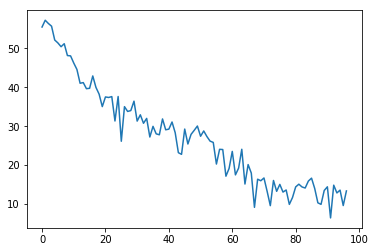

In [19]:
plt.plot(losses['total'])

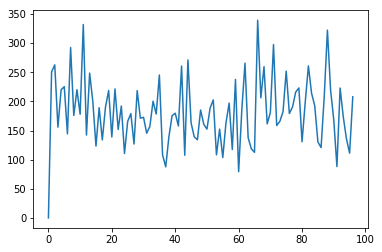

In [20]:
plt.plot(losses['loc'])

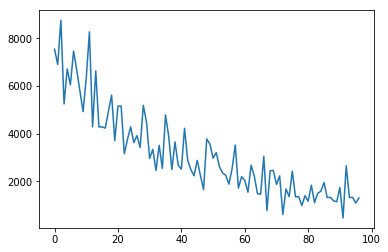

In [21]:
plt.plot(losses['conf'])

In [22]:
utils.save_model(model, dirname='../model_checkpoints/')

model saved at: ../model_checkpoints/model-2018-12-19T10:00:57.cpkt
